<a id='top'></a>

<a href='#import'>Import &amp; Inspect</a> | <a href='#first'>First Section</a>
    
<br>

---


# Academic Mastery Study - Machine Learning Analysis

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

<a href='#top' id='import'>back to menu</a>

## Import & Inspect

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sklearn.model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("poster")

# Set options to inspect ALL of the columns:
pd.options.display.max_columns = 325

## Test Dataset

In [2]:
# Read and save CSV file as a dataframe:
test_df = pd.read_csv('../data/raw/test.csv')
solution = pd.read_csv('../data/raw/solution_sorted.csv')

test_df = test_df[test_df.user_id.isin(solution.user_id.values)].drop(['date_of_test', 'question_set_id'], axis='columns')

# Loop through the time_columns list:
for column in ['round_started_at', 'answered_at', 'deactivated_at']:
    # Convert date strings to datetime objects; 
    # need to ‘coerce’ errors, since there are known NULL values:
    test_df[column] = pd.to_datetime(test_df[column], errors='coerce')
    
test_df = test_df.dropna(subset=['round_started_at'])
test_df['round_ended_at'] = test_df['answered_at'].fillna(test_df['deactivated_at'])       
test_df['round_duration'] = (test_df['round_ended_at'] - test_df['round_started_at']).astype(int)
test_df['prior_attempts'] = test_df.groupby(['user_id', 'question_id']).cumcount()

test = pd.merge(test_df, solution, on='user_id')
test.head()

,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,round_ended_at,round_duration,prior_attempts,correct
0,0,5186,0,0,2,10,62 91 127 206,2011-08-26 16:58:47,2011-08-26 16:59:01,2011-08-26 16:59:03,7,1,2011-08-26 16:59:01,14000000000,0,1
1,1,547,0,1,4,9,36 77 82 161 205,2011-02-14 08:10:03,2011-02-14 08:11:17,2011-02-14 08:11:18,2,1,2011-02-14 08:11:17,74000000000,0,0
2,2,1613,0,0,2,10,62 122 206 253,2011-11-08 16:31:28,2011-11-08 16:31:34,2011-11-08 16:31:36,5,1,2011-11-08 16:31:34,6000000000,0,1
3,4,2545,0,1,5,0,28 49,2010-02-09 04:52:29,2010-02-09 04:53:17,2010-02-09 04:53:30,7,2,2010-02-09 04:53:17,48000000000,0,1
4,5,2303,0,2,8,3,101 103 275,2011-01-17 18:22:30,2011-01-17 18:23:00,2011-01-17 18:23:02,7,1,2011-01-17 18:23:00,30000000000,0,0


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80777 entries, 0 to 80776
Data columns (total 16 columns):
user_id             80777 non-null int64
question_id         80777 non-null int64
question_type       80777 non-null int64
group_name          80777 non-null int64
track_name          80777 non-null int64
subtrack_name       80777 non-null int64
tag_string          80777 non-null object
round_started_at    80777 non-null datetime64[ns]
answered_at         80777 non-null datetime64[ns]
deactivated_at      80777 non-null datetime64[ns]
game_type           80777 non-null int64
num_players         80777 non-null int64
round_ended_at      80777 non-null datetime64[ns]
round_duration      80777 non-null int64
prior_attempts      80777 non-null int64
correct             80777 non-null int64
dtypes: datetime64[ns](4), int64(11), object(1)
memory usage: 10.5+ MB


### Extract Tags

In [4]:
# Split the space delimited tag_string into a list of tag_ids:
tags = test.tag_string.str.split(' ')

tags_df = pd.DataFrame(tags)

# Change the name of 'tag_string' column to tag_ids:
tags_df = tags_df.rename(columns = {'tag_string':'tag_ids'})

tags_df.head()

,tag_ids
0,"[62, 91, 127, 206]"
1,"[36, 77, 82, 161, 205]"
2,"[62, 122, 206, 253]"
3,"[28, 49]"
4,"[101, 103, 275]"


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X = mlb.fit_transform(tags_df.tag_ids)

tags_df = tags_df.join(pd.DataFrame(X, columns=mlb.classes_))

tags_df = tags_df.drop('tag_ids', axis=1)
tags_df.head()

,0,1,10,100,101,102,103,104,105,106,107,108,109,11,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,129,13,130,131,132,133,134,135,136,137,138,139,14,140,141,142,143,144,145,146,147,148,149,15,150,151,152,153,154,155,156,157,158,159,16,160,161,162,163,164,165,166,167,168,169,17,170,171,172,173,174,175,176,177,178,179,18,180,181,182,183,184,185,186,187,188,189,19,190,191,192,193,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,9,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Fill NULL values with 0 and convert all to integers:
tags_df = tags_df.fillna(0).astype('int')

In [7]:
# Re-order columns (which are ordered by string):
tags = list(tags_df.columns)
columns = sorted([int(x) for x in tags])
columns = [str(x) for x in columns]

In [8]:
tags_df = tags_df[columns]

In [9]:
# Rename each tag_id column:
tags_df = tags_df.rename(columns = lambda x : 'tag_' + str(x))
tags_df.head()

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,tag_207,tag_208,tag_209,tag_210,tag_211,tag_212,tag_213,tag_214,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_231,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_239,tag_240,tag_241,tag_242,tag_243,tag_244,tag_245,tag_246,tag_247,tag_248,tag_249,tag_250,tag_251,tag_252,tag_253,tag_254,tag_255,tag_256,tag_257,tag_258,tag_259,tag_260,tag_261,tag_262,tag_263,tag_264,tag_265,tag_266,tag_267,tag_268,tag_269,tag_270,tag_271,tag_272,tag_273,tag_274,tag_275,tag_276,tag_277,tag_278,tag_279,tag_280
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [10]:
# Concatenate the tags dataframe with the original dataframe:
test = pd.concat([test[:], tags_df[:]], axis=1)

# Re-inspect the state and structure of the dataframe:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80777 entries, 0 to 80776
Columns: 297 entries, user_id to tag_280
dtypes: datetime64[ns](4), int64(292), object(1)
memory usage: 183.7+ MB
None


,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,round_ended_at,round_duration,prior_attempts,correct,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,tag_207,tag_208,tag_209,tag_210,tag_211,tag_212,tag_213,tag_214,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_231,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_239,tag_240,tag_241,tag_242,tag_243,tag_244,tag_245,tag_246,tag_247,tag_248,tag_249,tag_250,tag_251,tag_252,tag_253,tag_254,tag_255,tag_256,tag_257,tag_258,tag_259,tag_260,tag_261,tag_262,tag_263,tag_264,tag_265,tag_266,tag_267,tag_268,tag_269,tag_270,tag_271,tag_272,tag_273,tag_274,tag_275,tag_276,tag_277,tag_278,tag_279,tag_280
0,0,5186,0,0,2,10,62 91 127 206,2011-08-26 16:58:47,2011-08-26 16:59:01,2011-08-26 16:59:03,7,1,2011-08-26 16:59:01,14000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,547,0,1,4,9,36 77 82 161 205,2011-02-14 08:10:03,2011-02-14 08:11:17,2011-02-14 08:11:18,2,1,2011-02-14 08:11:17,74000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1613,0,0,2,10,62 122 206 253,2011-11-08 16:31:28,2011-11-08 16:31:34,2011-11-08 16:31:36,5,1,2011-11-08 16:31:34,6000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,

## Helper Functions

In [11]:
# Define a generic replace function -

def code_values(column, code_dictionary):
    """Return a column of codes defined in a dictionary."""
    
    # Initialize the replacement column:
    coded_column = pd.Series(column, copy=True)
    
    # Loop throught the provided dictionary:
    for key, value in code_dictionary.items():
        
        # Replace key with the value within the original column:
        coded_column.replace(key, value, inplace=True)
        
    return coded_column

# Save dictionary with codes and semantic values:
groups = {0:'act', 1:'gmat', 2:'sat'}

# Convert and save:
test.group_name = code_values(test.group_name, groups)

In [12]:
def plot_roc_curve(model, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve
    model.fit(X_train, y_train)
    accuracy = accuracy_score(model.predict(X_train), y_train)
    probabilities = model.predict_proba(X_test)[:, 1]

    print('Accuracy:', accuracy)
    print()
    false_positive, true_positive, threshold = roc_curve(y_test, probabilities)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive, true_positive)
    plt.plot([0, 1], ls="--")
    plt.xlabel('False Positive')
    plt.ylabel('True Positive');

In [13]:
def plot_validation_curve(model, X_train, y_train, param_name, param_range, scoring='accuracy', fill=True):
    from sklearn.model_selection import validation_curve
    train_scores, test_scores = validation_curve(
        model, 
        X_train, 
        y_train, 
        param_name=param_name, 
        param_range=param_range, 
        scoring=scoring, 
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(param_range, train_mean, label='Training Score')
    plt.plot(param_range, test_mean, label='Cross-validation Score')
    
    if fill:
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='lightblue')
        plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='lightgrey')

    plt.title('Validation Curve')
    plt.xlabel('Hyperparameter Value')
    plt.ylabel('Score')
    plt.legend(loc='best');

## ACT Dataset

In [14]:
# Read and save CSV file a as dataframe:
act = pd.read_csv('../data/interim/clean_act.csv').drop('Unnamed: 0', axis='columns')

# Convert round_duration to timedelta:
act['round_duration'] = pd.to_timedelta(act.round_duration, unit='s').astype(int)

act.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg
0,121052,2011-11-10 18:32:18,2011-11-10 18:32:44,2011-11-10 18:33:21,2011-11-10 18:32:44,1,3010,act,3,12,22 51 56 61 114 243,0,7,3,26000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0
1,121052,2011-11-10 18:34:49,2011-11-10 18:35:45,2011-11-10 18:35:47,2011-11-10 18:35:45,1,4446,act,3,12,16 22 50 51 123 243,0,7,2,56000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0
2,121052,2011-11-10 18:36:03,2011-11-10 18:36:50,2011-11-10 18:37:06,2011-11-10 18:36:50,1,1488,act,3,12,34 51 61 114 123 146 152 243,0,7,2,47000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0
3,121052,2011-11-10 18:37:15,2011-11-10 18:37:31,2011-11-10 18:37:45,2011-11-10 18:37:31,1,787,act,3,12,6 34 50 51 102 114 152 243,0,7,2,16000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0
4,121052,2011-11-10 18:37:50,2011-11-10 18:38:15,2011-11-10 18:38:17,2011-11-10 18:38:15,1,2526,act,3,12,34 50 152 162 212 243,0,7,2,25000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0


### Extract Tags

In [15]:
# Split the space delimited tag_string into a list of tag_ids:
tags = act.tag_string.str.split(' ')

tags_df = pd.DataFrame(tags)

# Change the name of 'tag_string' column to tag_ids:
tags_df = tags_df.rename(columns = {'tag_string':'tag_ids'})

tags_df.head()

,tag_ids
0,"[22, 51, 56, 61, 114, 243]"
1,"[16, 22, 50, 51, 123, 243]"
2,"[34, 51, 61, 114, 123, 146, 152, 243]"
3,"[6, 34, 50, 51, 102, 114, 152, 243]"
4,"[34, 50, 152, 162, 212, 243]"


In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

X = mlb.fit_transform(tags_df.tag_ids)

tags_df = tags_df.join(pd.DataFrame(X, columns=mlb.classes_))

tags_df = tags_df.drop('tag_ids', axis=1)
tags_df.head()

,0,100,102,103,104,107,109,112,114,120,122,123,124,125,126,127,128,129,130,132,133,135,139,140,141,143,144,146,148,151,152,153,155,156,158,16,162,165,167,168,169,17,171,172,173,18,2,20,204,206,208,209,21,210,212,214,216,217,22,242,243,244,247,249,253,254,255,259,260,263,265,267,268,272,273,274,276,278,279,280,32,33,34,35,38,39,40,42,43,44,45,46,50,51,54,56,57,6,61,62,63,64,65,70,72,75,8,81,82,85,86,89,9,90,91
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Fill NULL values with 0 and convert all to integers:
tags_df = tags_df.fillna(0).astype('int')

In [18]:
# Re-order columns (which are ordered by string):
tags = list(tags_df.columns)
columns = sorted([int(x) for x in tags])
columns = [str(x) for x in columns]

In [19]:
tags_df = tags_df[columns]

In [20]:
# Rename each tag_id column:
tags_df = tags_df.rename(columns = lambda x : 'tag_' + str(x))
tags_df.head()

,tag_0,tag_2,tag_6,tag_8,tag_9,tag_16,tag_17,tag_18,tag_20,tag_21,tag_22,tag_32,tag_33,tag_34,tag_35,tag_38,tag_39,tag_40,tag_42,tag_43,tag_44,tag_45,tag_46,tag_50,tag_51,tag_54,tag_56,tag_57,tag_61,tag_62,tag_63,tag_64,tag_65,tag_70,tag_72,tag_75,tag_81,tag_82,tag_85,tag_86,tag_89,tag_90,tag_91,tag_100,tag_102,tag_103,tag_104,tag_107,tag_109,tag_112,tag_114,tag_120,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_132,tag_133,tag_135,tag_139,tag_140,tag_141,tag_143,tag_144,tag_146,tag_148,tag_151,tag_152,tag_153,tag_155,tag_156,tag_158,tag_162,tag_165,tag_167,tag_168,tag_169,tag_171,tag_172,tag_173,tag_204,tag_206,tag_208,tag_209,tag_210,tag_212,tag_214,tag_216,tag_217,tag_242,tag_243,tag_244,tag_247,tag_249,tag_253,tag_254,tag_255,tag_259,tag_260,tag_263,tag_265,tag_267,tag_268,tag_272,tag_273,tag_274,tag_276,tag_278,tag_279,tag_280
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# Concatenate the tags dataframe with the original dataframe:
act = pd.concat([act[:], tags_df[:]], axis=1)

# Re-inspect the state and structure of the dataframe:
print(act.info())
act.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736696 entries, 0 to 736695
Columns: 145 entries, user_id to tag_280
dtypes: float64(1), int64(135), object(9)
memory usage: 815.0+ MB
None


,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,correct,question_id,group_name,track_name,subtrack_name,tag_string,question_type,game_type,num_players,round_duration,fast,slow,prior_attempts,excessive_attempts,outcome,num_correct,num_incorrect,num_questions,few,many,correct_ratio,total_practice,round_duration_avg,slow_avg,fast_avg,tag_0,tag_2,tag_6,tag_8,tag_9,tag_16,tag_17,tag_18,tag_20,tag_21,tag_22,tag_32,tag_33,tag_34,tag_35,tag_38,tag_39,tag_40,tag_42,tag_43,tag_44,tag_45,tag_46,tag_50,tag_51,tag_54,tag_56,tag_57,tag_61,tag_62,tag_63,tag_64,tag_65,tag_70,tag_72,tag_75,tag_81,tag_82,tag_85,tag_86,tag_89,tag_90,tag_91,tag_100,tag_102,tag_103,tag_104,tag_107,tag_109,tag_112,tag_114,tag_120,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_132,tag_133,tag_135,tag_139,tag_140,tag_141,tag_143,tag_144,tag_146,tag_148,tag_151,tag_152,tag_153,tag_155,tag_156,tag_158,tag_162,tag_165,tag_167,tag_168,tag_169,tag_171,tag_172,tag_173,tag_204,tag_206,tag_208,tag_209,tag_210,tag_212,tag_214,tag_216,tag_217,tag_242,tag_243,tag_244,tag_247,tag_249,tag_253,tag_254,tag_255,tag_259,tag_260,tag_263,tag_265,tag_267,tag_268,tag_272,tag_273,tag_274,tag_276,tag_278,tag_279,tag_280
0,121052,2011-11-10 18:32:18,2011-11-10 18:32:44,2011-11-10 18:33:21,2011-11-10 18:32:44,1,3010,act,3,12,22 51 56 61 114 243,0,7,3,26000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,121052,2011-11-10 18:34:49,2011-11-10 18:35:45,2011-11-10 18:35:47,2011-11-10 18:35:45,1,4446,act,3,12,16 22 50 51 123 243,0,7,2,56000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,121052,2011-11-10 18:36:03,2011-11-10 18:36:50,2011-11-10 18:37:06,2011-11-10 18:36:50,1,1488,act,3,12,34 51 61 114 123 146 152 243,0,7,2,47000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,121052,2011-11-10 18:37:15,2011-11-10 18:37:31,2011-11-10 18:37:45,2011-11-10 18:37:31,1,787,act,3,12,6 34 50 51 102 114 152 243,0,7,2,16000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,121052,2011-11-10 18:37:50,2011-11-10 18:38:15,2011-11-10 18:38:17,2011-11-10 18:38:15,1,2526,act,3,12,34 50 152 162 212 243,0,7,2,25000000000,0,0,0,0,correct,6,0,6,0,0,1.0,0 days 00:03:20.000000000,0 days 00:00:33.333333333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
act_test = test[test['group_name'] == 'act']
act_test.head()

,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,round_ended_at,round_duration,prior_attempts,correct,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28,tag_29,tag_30,tag_31,tag_32,tag_33,tag_34,tag_35,tag_36,tag_37,tag_38,tag_39,tag_40,tag_41,tag_42,tag_43,tag_44,tag_45,tag_46,tag_47,tag_48,tag_49,tag_50,tag_51,tag_52,tag_53,tag_54,tag_55,tag_56,tag_57,tag_58,tag_59,tag_60,tag_61,tag_62,tag_63,tag_64,tag_65,tag_66,tag_67,tag_68,tag_69,tag_70,tag_71,tag_72,tag_73,tag_74,tag_75,tag_76,tag_77,tag_78,tag_79,tag_80,tag_81,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99,tag_100,tag_101,tag_102,tag_103,tag_104,tag_105,tag_106,tag_107,tag_108,tag_109,tag_110,tag_111,tag_112,tag_113,tag_114,tag_115,tag_116,tag_117,tag_118,tag_119,tag_120,tag_121,tag_122,tag_123,tag_124,tag_125,tag_126,tag_127,tag_128,tag_129,tag_130,tag_131,tag_132,tag_133,tag_134,tag_135,tag_136,tag_137,tag_138,tag_139,tag_140,tag_141,tag_142,tag_143,tag_144,tag_145,tag_146,tag_147,tag_148,tag_149,tag_150,tag_151,tag_152,tag_153,tag_154,tag_155,tag_156,tag_157,tag_158,tag_159,tag_160,tag_161,tag_162,tag_163,tag_164,tag_165,tag_166,tag_167,tag_168,tag_169,tag_170,tag_171,tag_172,tag_173,tag_174,tag_175,tag_176,tag_177,tag_178,tag_179,tag_180,tag_181,tag_182,tag_183,tag_184,tag_185,tag_186,tag_187,tag_188,tag_189,tag_190,tag_191,tag_192,tag_193,tag_194,tag_195,tag_196,tag_197,tag_198,tag_199,tag_200,tag_201,tag_202,tag_203,tag_204,tag_205,tag_206,tag_207,tag_208,tag_209,tag_210,tag_211,tag_212,tag_213,tag_214,tag_215,tag_216,tag_217,tag_218,tag_219,tag_220,tag_221,tag_222,tag_223,tag_224,tag_225,tag_226,tag_227,tag_228,tag_229,tag_230,tag_231,tag_232,tag_233,tag_234,tag_235,tag_236,tag_237,tag_238,tag_239,tag_240,tag_241,tag_242,tag_243,tag_244,tag_245,tag_246,tag_247,tag_248,tag_249,tag_250,tag_251,tag_252,tag_253,tag_254,tag_255,tag_256,tag_257,tag_258,tag_259,tag_260,tag_261,tag_262,tag_263,tag_264,tag_265,tag_266,tag_267,tag_268,tag_269,tag_270,tag_271,tag_272,tag_273,tag_274,tag_275,tag_276,tag_277,tag_278,tag_279,tag_280
0,0,5186,0,act,2,10,62 91 127 206,2011-08-26 16:58:47,2011-08-26 16:59:01,2011-08-26 16:59:03,7,1,2011-08-26 16:59:01,14000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1613,0,act,2,10,62 122 206 253,2011-11-08 16:31:28,2011-11-08 16:31:34,2011-11-08 16:31:36,5,1,2011-11-08 16:31:34,6000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,2030,0,act,3,12,6 50 51 129 152 243,2011-06-04 20:43:42,2011-06-04 20:44:36,2011-06-04 20:44:37,7,1,2011-06-04 20:44:36,54000000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0

### LOGISTIC REGRESSION
---

In [23]:
model = LogisticRegression()
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

### User ID and Question ID

In [24]:
X_train_act = act[['user_id', 'question_id']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id']]
y_test_act = act_test.correct

Accuracy: 0.5031505532811363



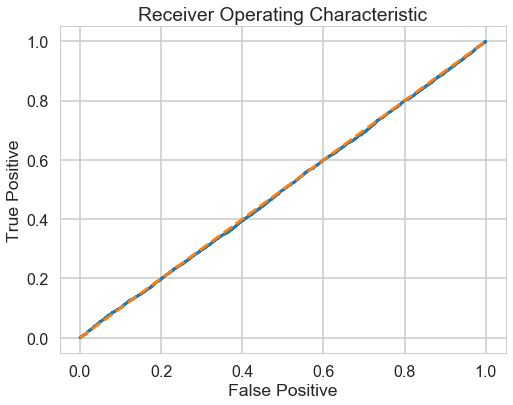

In [25]:
plot_roc_curve(model, X_train_act, y_train_act, X_test_act, y_test_act)

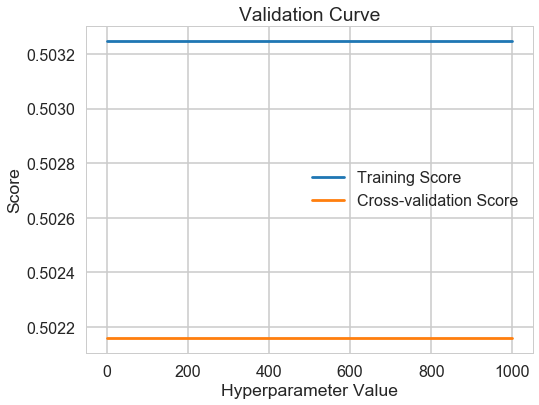

In [26]:
plot_validation_curve(model, X_train_act, y_train_act, param_name, param_range, fill=False)

### Raw Dataset Variables

In [27]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_test_act = act_test.correct

Accuracy: 0.5382763039299793



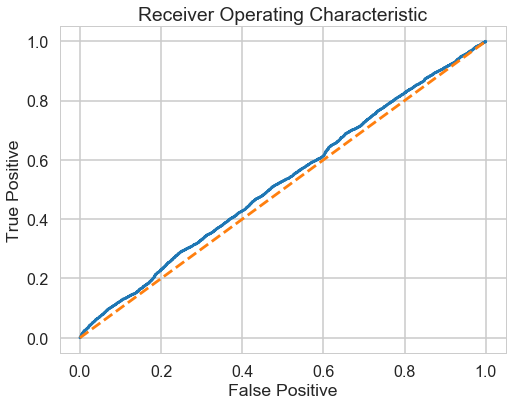

In [28]:
plot_roc_curve(model, X_train_act, y_train_act, X_test_act, y_test_act)

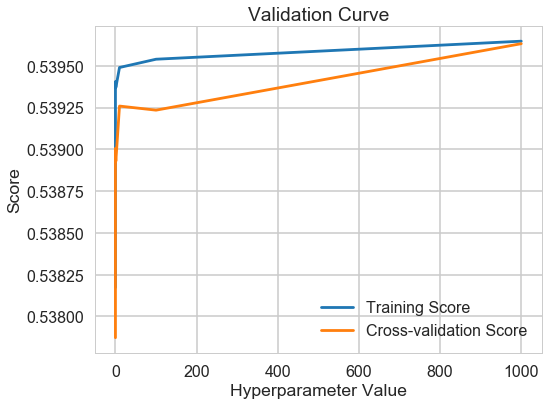

In [29]:
plot_validation_curve(model, X_train_act, y_train_act, param_name, param_range, fill=False)

### Raw Dataset Variables + Engineered Features

In [30]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

Accuracy: 0.4990172337029114



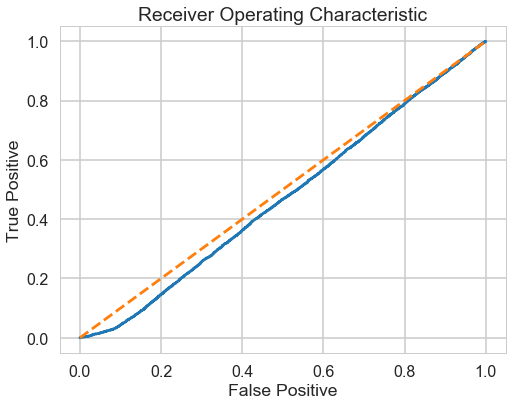

In [31]:
plot_roc_curve(model, X_train_act, y_train_act, X_test_act, y_test_act)

### User ID and Question ID + Engineered Features

In [32]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

Accuracy: 0.4990172337029114



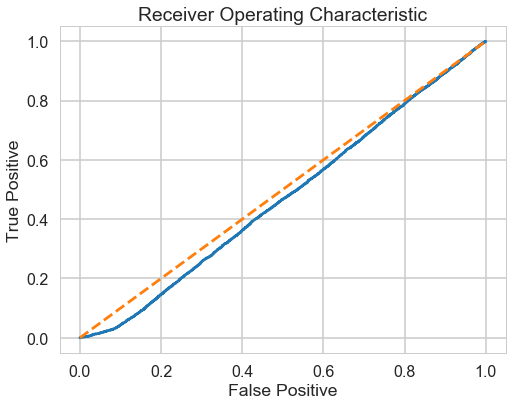

In [33]:
plot_roc_curve(model, X_train_act, y_train_act, X_test_act, y_test_act)

### User ID and Question ID + Track and Engineered Features

In [34]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

Accuracy: 0.4990172337029114



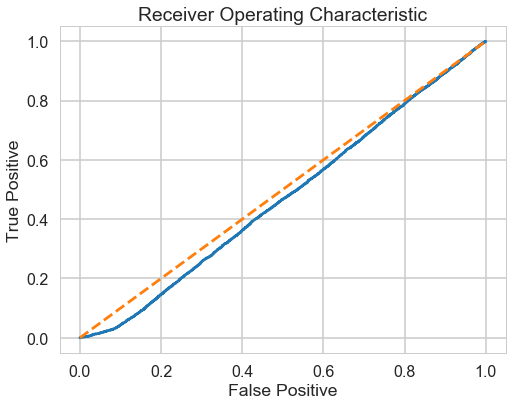

In [35]:
plot_roc_curve(model, X_train_act, y_train_act, X_test_act, y_test_act)

### DECISION TREES & RANDOM FOREST
---

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestClassifier

In [37]:
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X_train_act, y_train_act)
# dot_data = tree.export_graphviz(
#     clf, 
#     class_names=True,
#     feature_names=feature_names,
#     out_file=None, 
#     filled=True, 
#     rounded=True
# )
# graph = graphviz.Source(dot_data)
# graph

### User ID and Question ID

In [38]:
X_train_act = act[['user_id', 'question_id']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id']]
y_test_act = act_test.correct

In [39]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.50      0.50      0.50      9680
          1       0.49      0.49      0.49      9394

avg / total       0.50      0.50      0.50     19074



[('user_id', 0.8587909160501452), ('question_id', 0.14120908394985474)]

In [40]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.53      0.50      0.52     10262
          1       0.46      0.49      0.48      8812

avg / total       0.50      0.50      0.50     19074



[('user_id', 0.7119861885881212), ('question_id', 0.28801381141187876)]

### Raw Dataset Variables

In [41]:
X_train_act = act[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_test_act = act_test.correct

In [42]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.51      0.50      0.51      9690
          1       0.49      0.50      0.50      9384

avg / total       0.50      0.50      0.50     19074



[('user_id', 0.7400986133151928),
 ('question_id', 0.17547412792380307),
 ('question_type', 0.0),
 ('track_name', 0.010424612303202645),
 ('subtrack_name', 0.005894217734627073),
 ('game_type', 0.018865319990599854),
 ('num_players', 0.04924310873257442)]

In [43]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.55      0.51      0.53     10336
          1       0.46      0.50      0.48      8738

avg / total       0.51      0.50      0.51     19074



[('user_id', 0.6865751199397179),
 ('question_id', 0.28224372150767196),
 ('question_type', 0.0),
 ('track_name', 0.0027849243818288153),
 ('subtrack_name', 0.0038399751253859046),
 ('game_type', 0.012964799540056216),
 ('num_players', 0.011591459505339392)]

### Raw Dataset Variables + Engineered Features

In [44]:
X_train_act = act[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

In [45]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.51      0.51      0.51      9575
          1       0.51      0.51      0.51      9499

avg / total       0.51      0.51      0.51     19074



[('user_id', 0.4465772220575225),
 ('question_id', 0.21639147278541795),
 ('question_type', 0.0),
 ('track_name', 0.00988081448006014),
 ('subtrack_name', 0.012125159572867163),
 ('game_type', 0.019945014268382924),
 ('num_players', 0.037241690888335365),
 ('round_duration', 0.23902942920302067),
 ('prior_attempts', 0.01880919674439333)]

In [46]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.58      0.52      0.55     10782
          1       0.45      0.52      0.48      8292

avg / total       0.53      0.52      0.52     19074



[('user_id', 0.4216479071806293),
 ('question_id', 0.279199312738435),
 ('question_type', 0.0),
 ('track_name', 0.005246591289242439),
 ('subtrack_name', 0.00511431954705265),
 ('game_type', 0.016274476394199426),
 ('num_players', 0.01959890545390346),
 ('round_duration', 0.24256289496107594),
 ('prior_attempts', 0.010355592435461768)]

### User ID and Question ID + Engineered Features

In [47]:
X_train_act = act[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

In [48]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.52      0.52      0.52      9617
          1       0.51      0.51      0.51      9457

avg / total       0.51      0.51      0.51     19074



[('user_id', 0.5117624690494839),
 ('question_id', 0.2388136422324849),
 ('round_duration', 0.2349805385077156),
 ('prior_attempts', 0.014443350210315531)]

In [49]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.58      0.51      0.54     10707
          1       0.45      0.51      0.48      8367

avg / total       0.52      0.51      0.52     19074



[('user_id', 0.4699504072388786),
 ('question_id', 0.31021325347475337),
 ('round_duration', 0.20821502445070045),
 ('prior_attempts', 0.011621314835667527)]

### User ID and Question ID + Track and Engineered Features

In [50]:
X_train_act = act[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

In [51]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.51      0.51      0.51      9574
          1       0.51      0.51      0.51      9500

avg / total       0.51      0.51      0.51     19074



[('user_id', 0.5077587793891091),
 ('question_id', 0.21222697060006226),
 ('track_name', 0.010982531523209861),
 ('subtrack_name', 0.00796750946101609),
 ('round_duration', 0.24440921822352699),
 ('prior_attempts', 0.016654990803075757)]

In [52]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train_act, y_train_act)
predicted = clf.predict(X_test_act)

print(classification_report(predicted, y_test_act))
list(zip(X_train_act, clf.feature_importances_))

             precision    recall  f1-score   support

          0       0.57      0.51      0.54     10670
          1       0.45      0.51      0.48      8404

avg / total       0.52      0.51      0.51     19074



[('user_id', 0.4630248904810341),
 ('question_id', 0.3042799811197535),
 ('track_name', 0.0027644026538789085),
 ('subtrack_name', 0.0049170793037098945),
 ('round_duration', 0.2170804704095243),
 ('prior_attempts', 0.007933176032099228)]

### LINEAR MIXED EFFECTS
---
http://www.statsmodels.org/dev/mixed_linear.html

http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html#statsmodels.regression.mixed_linear_model.MixedLM

http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html#statsmodels.regression.mixed_linear_model.MixedLM.from_formula

### User ID and Question ID

In [53]:
y_train_act = act.correct
X_train_act = act[['question_id']]
g_train_act = act['user_id']

y_test_act = act_test.correct
X_test_act = act_test[['question_id']]
g_test_act = act_test['user_id']

In [54]:
model = sm.MixedLM(y_train_act, X_train_act, g_train_act).fit()
print(model.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct     
No. Observations: 736696  Method:             REML        
No. Groups:       38517   Scale:              0.2225      
Min. group size:  1       Likelihood:         -528102.9474
Max. group size:  5209    Converged:          Yes         
Mean group size:  19.1                                    
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
question_id  0.000     0.000  54.865  0.000   0.000   0.000
Group RE     0.168     0.003                               



### Raw Dataset Variables

In [55]:
y_train_act = act.correct
X_train_act = act[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
g_train_act = act['user_id']
Z_train_act = np.ones((len(X_train_act), 1))

y_test_act = act_test.correct
X_test_act = act_test[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
g_test_act = act_test['user_id']
Z_test_act = np.ones((len(X_test_act), 1))

In [56]:
model = sm.MixedLM(y_train_act, X_train_act, g_train_act, Z_train_act).fit()
print(model.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct     
No. Observations: 736696  Method:             REML        
No. Groups:       38517   Scale:              0.2233      
Min. group size:  1       Likelihood:         -510059.3620
Max. group size:  5209    Converged:          Yes         
Mean group size:  19.1                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
question_id     0.000    0.000   9.823 0.000  0.000  0.000
track_name     -0.229    0.004 -53.917 0.000 -0.238 -0.221
subtrack_name   0.061    0.001  51.490 0.000  0.059  0.063
game_type       0.042    0.000 109.053 0.000  0.041  0.043
num_players    -0.003    0.001  -4.761 0.000 -0.004 -0.002
x_re1 RE        0.034    0.001                            



### Raw Dataset Variables + Engineered Features

In [57]:
y_train_act = act.correct
X_train_act = act[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
g_train_act = act['user_id']

y_test_act = act_test.correct
X_test_act = act_test[['question_id', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
g_test_act = act_test['user_id']

In [58]:
model = sm.MixedLM(y_train_act, X_train_act, g_train_act).fit()
print(model.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct     
No. Observations: 736696  Method:             REML        
No. Groups:       38517   Scale:              0.2221      
Min. group size:  1       Likelihood:         -508013.7696
Max. group size:  5209    Converged:          Yes         
Mean group size:  19.1                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
question_id     0.000    0.000  11.453 0.000  0.000  0.000
track_name     -0.253    0.004 -59.466 0.000 -0.261 -0.245
subtrack_name   0.069    0.001  58.022 0.000  0.066  0.071
game_type       0.042    0.000 108.505 0.000  0.041  0.043
num_players    -0.000    0.001  -0.803 0.422 -0.002  0.001
round_duration -0.000    0.000 -57.915 0.000 -0.000 -0.000
prior_attempts  0.025    0.001  26.787 0.000  0.023  0.027
Group RE

### User ID and Question ID + Engineered Features

In [59]:
y_train_act = act.correct
X_train_act = act[['question_id', 'round_duration', 'prior_attempts']]
g_train_act = act['user_id']

y_test_act = act_test.correct
X_test_act = act_test[['question_id', 'round_duration', 'prior_attempts']]
g_test_act = act_test['user_id']

In [60]:
model = sm.MixedLM(y_train_act, X_train_act, g_train_act).fit()
print(model.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: correct     
No. Observations: 736696  Method:             REML        
No. Groups:       38517   Scale:              0.2214      
Min. group size:  1       Likelihood:         -527007.5971
Max. group size:  5209    Converged:          Yes         
Mean group size:  19.1                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
question_id     0.000    0.000  55.604 0.000  0.000  0.000
round_duration -0.000    0.000 -34.491 0.000 -0.000 -0.000
prior_attempts  0.030    0.001  31.553 0.000  0.028  0.032
Group RE        0.175    0.004                            



### User ID and Question ID + Track and Engineered Features

In [61]:
y_train_act = act.correct
X_train_act = act[['question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
g_train_act = act['user_id']

y_test_act = act_test.correct
X_test_act = act_test[['question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
g_test_act = act_test['user_id']

In [62]:
model = sm.MixedLM(y_train_act, X_train_act, g_train_act).fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: correct     
No. Observations:  736696  Method:             REML        
No. Groups:        38517   Scale:              0.2242      
Min. group size:   1       Likelihood:         -513840.3989
Max. group size:   5209    Converged:          Yes         
Mean group size:   19.1                                    
-----------------------------------------------------------
               Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------
question_id     0.000    0.000   27.683 0.000  0.000  0.000
track_name     -0.580    0.003 -189.644 0.000 -0.586 -0.574
subtrack_name   0.164    0.001  201.741 0.000  0.162  0.166
round_duration -0.000    0.000  -55.543 0.000 -0.000 -0.000
prior_attempts  0.030    0.001   31.752 0.000  0.028  0.032
Group RE        0.043    0.001                             



### MIXED EFFECTS RANDOM FOREST
---
article from creators: https://towardsdatascience.com/mixed-effects-random-forests-6ecbb85cb177

MERF repository: https://github.com/manifoldai/merf

In [63]:
from merf.merf import MERF

### User ID and Question ID

In [ ]:
# LME models:
y_train_act = act.correct
X_train_act = act[['question_id']]
g_train_act = act['user_id']

y_test_act = act_test.correct
X_test_act = act_test[['question_id']]
g_test_act = act_test['user_id']

### Raw Dataset Variables

In [ ]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players']]
y_test_act = act_test.correct

### Raw Dataset Variables + Engineered Features

In [ ]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'question_type', 'track_name', 'subtrack_name', 'game_type', 'num_players', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

### User ID and Question ID + Engineered Features

In [ ]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

### User ID and Question ID + Track and Engineered Features

In [ ]:
# LogReg, DT/RF models:
X_train_act = act[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_train_act = act.correct

X_test_act = act_test[['user_id', 'question_id', 'track_name', 'subtrack_name', 'round_duration', 'prior_attempts']]
y_test_act = act_test.correct

From the competition website; contents of `benchmark_lmer.r` file in R:

In [ ]:
# read in training data
training = read.csv("training.csv", header=TRUE, comment.char = "", colClasses = c('integer','integer','integer','integer','NULL','NULL','integer','integer','NULL','NULL','NULL','NULL','NULL','NULL','NULL','NULL','NULL'))
# only keep correct and incorrect outcomes
training = training[training$outcome == 1 | training$outcome == 2,]
# read in test data
test = read.csv("test.csv", header=TRUE, as.is=TRUE)

# import lme4 for lmer
require('lme4')

# create a simple logit function for computing probabilities
logit <- function(x) {
  (1 + exp(-x))^-1
}

## fit models

# fit a basic Rasch-style model for each track separately
track_models = list()
for (track in unique(training$track_name)) {
  
  print(sprintf("Starting model for track %s.",track))
  rasch = lmer(correct ~ 1 + (1|user_id) + (1|question_id), data=training[training$track_name==track,c("correct","user_id","question_id")], family=binomial, REML=FALSE)

  # get the constant term
  constant = fixef(rasch)["(Intercept)"]

  # get the estimated per-question 'random' effects into a named vector
  question_est = as.vector(t(ranef(rasch)[['question_id']]))
  names(question_est) = rownames(ranef(rasch)[['question_id']])

  # get the estimated per-user 'random' effects into a named vector
  user_est = as.vector(t(ranef(rasch)[['user_id']]))
  names(user_est) = rownames(ranef(rasch)[['user_id']])

  # store these coefficients for later use
  track_models[[as.character(track)]] = list(constant=constant, question_est=question_est, user_est=user_est)
  print(sprintf("Finished with model for %s.",track))
}

## make predictions

# use those model parameters to predict the probability of each test example, using the appropriate track model
predictions = rep(0.5, nrow(test))
for (row_id in (1:nrow(test))) {
  #print(sprintf("Predicting for row %0.0f.",row_id))
  user_id =  test[row_id,"user_id"]
  question_id = test[row_id,"question_id"]
  track = test[row_id, "track_name"]
  #print(sprintf("  using track %s",track))
  model_info = track_models[[as.character(track)]]
  # get the logit of the sum -- if any of the parameters have no estimates/are NA, we effectively use 0 as their estimate
  predictions[row_id] = logit(sum(c(model_info[["constant"]], model_info[["question_est"]][as.character(question_id)], model_info[["user_est"]][as.character(user_id)]), na.rm=TRUE))
}

## output

# output the predictions as a csv to upload to kaggle
submission_df = data.frame(user_id = test$user_id, outcome=predictions)
write.csv(submission_df, file="submission_lmer.csv", row.names=FALSE)


<a href='#top' id='summary'>back to menu</a>

### Summary and Conclusions